## Introduction

## In this class  we discuss Consumer health informatics and provide some examples of the kinds of data collected, the analyses performed, and visulizations used to educate and motivate individuals with type 2 diabetes as an example. 

### CGM Data
### Go here to learn more about what a [continuous glucose monitor](https://www.niddk.nih.gov/health-information/diabetes/overview/managing-diabetes/continuous-glucose-monitoring) is

### Open the following slides, which are in your CHI folder: "CHI_Lecture.pdf"

require(dplyr)
cgm<- read.csv ("CGM_vals.csv", header=T, na.strings="")
cgm$DisplayTime<-  strptime(cgm$DisplayTime, format = "%m/%d/%Y %H:%M", tz = "")
cgm$DisplayTime<- as.POSIXct(cgm$DisplayTime)

cgm$bg.value<- cgm$Value
cgm<- arrange(cgm, ID)

##  Intensity data

In [2]:
pa.intensity<- read.csv ("Intensity.csv", header=T, na.strings="")
pa.intensity$ActivityMinute<-  strptime(pa.intensity$ActivityMinute, format = "%m/%d/%Y %H:%M", tz = "")
pa.intensity$ActivityMinute <- as.POSIXct(pa.intensity$ActivityMinute)
pa.intensity$ID<- pa.intensity$id

pa.intensity<- arrange(pa.intensity,ID)

## Steps Data

In [3]:
pa.steps <- read.csv ("min_steps.csv", header=T, na.strings="")
names(pa.steps)
pa.steps$ActivityMinute <-  strptime(pa.steps$ActivityMinute, format = "%m/%d/%Y %H:%M", tz = "")
pa.steps$ActivityMinute <- as.POSIXct(pa.steps$ActivityMinute)



[1] "ID"             "ActivityMinute" "steps"

## Heart Rate

In [4]:
hr<- read.csv ("hr.csv", header=T, na.strings="")
names(hr)
hr$Time<-  strptime(hr$Time, format = "%m/%d/%Y %H:%M", tz = "")
hr$Time<- as.POSIXct(hr$Time)
hr$hr.value<-hr$Value

[1] "ID"    "Time"  "Value"

### Choose every 5th row of fibit data to match

In [5]:
row.index.steps<-  1:nrow(pa.steps)
choose.index.steps<- row.index.steps[seq(1,max(row.index.steps),5)]
pa.steps<- pa.steps[c(choose.index.steps), ]

row.index.intensity<-  1:nrow(pa.intensity)
choose.index.intensity<- row.index.intensity[seq(1,max(row.index.intensity),5)]
pa.intensity<- pa.intensity[c(choose.index.intensity), ]

row.index.hr<-  1:nrow(hr)
choose.index.hr<- row.index.hr[seq(1,max(row.index.hr),5)]
hr<- hr[c(choose.index.hr), ]

## Match CGM and FitBit Data

In [6]:
require(dplyr)
cgm<- arrange(cgm, ID)
pa.steps<- arrange(pa.steps,ID)
pa.intensity<- arrange(pa.intensity, ID)
hr<- arrange(hr, ID)

###
res <- rep(0,length(cgm$ID))
res2 <- rep(0,length(pa.steps$ID))
res3 <- rep(0,length(pa.intensity$ID))
res4 <- rep(0,length(hr$ID))


for( i in 1:length(res)) res[i] <- ifelse(cgm$ID[i] %in% pa.steps$ID ==T, 1, 0)
for( i in 1:length(res2)) res2[i] <- ifelse(pa.steps$ID[i] %in% cgm$ID ==T, 1, 0)
for( i in 1:length(res3)) res3[i] <- ifelse(pa.intensity$ID[i] %in% cgm$ID ==T, 1, 0)
for( i in 1:length(res4)) res4[i] <- ifelse(hr$ID[i] %in% cgm$ID ==T, 1, 0)


cgm$match<- res
pa.steps$match<-res2
pa.intensity$match<-res3
hr$match<-res4


cgm<- subset(cgm, match==1)
pa.steps<- subset(pa.steps, match==1)
pa.intensity<- subset(pa.intensity, match==1)
hr<- subset(hr, match==1)


 ## Create the combined dataset 

In [7]:
length( unique(cgm$ID))
length( unique(pa.steps$ID))
length( unique(pa.intensity$ID))
length( unique(hr$ID))

nrow(cgm)
nrow(pa.steps)
nrow(pa.intensity)
nrow(hr)

hr<-hr[1:31260,c( "ID","Time","hr.value" )]
cgm<- cgm[1:31260,c("ID","bg.value", "DisplayTime")]
pa.steps<-pa.steps[1:31260,c("ID","steps") ]
pa.intensity<-pa.intensity[1:31260, c("ID","Intensity")]

combined<-cbind(hr,cgm,pa.steps,pa.intensity)
combined <- combined[,c (1,3,5,6,8,10)]
combined$bg.value<- as.integer(combined$bg.value)
combined$Time <- format(combined$Time, "%H:%M")


[1] 20

[1] 20

[1] 20

[1] 20

[1] 35771

[1] 45792

[1] 46080

[1] 31260

##   EXAMPLE PLOT OF DAILY GLUCOSE CURVE WITH CONTROL LINES

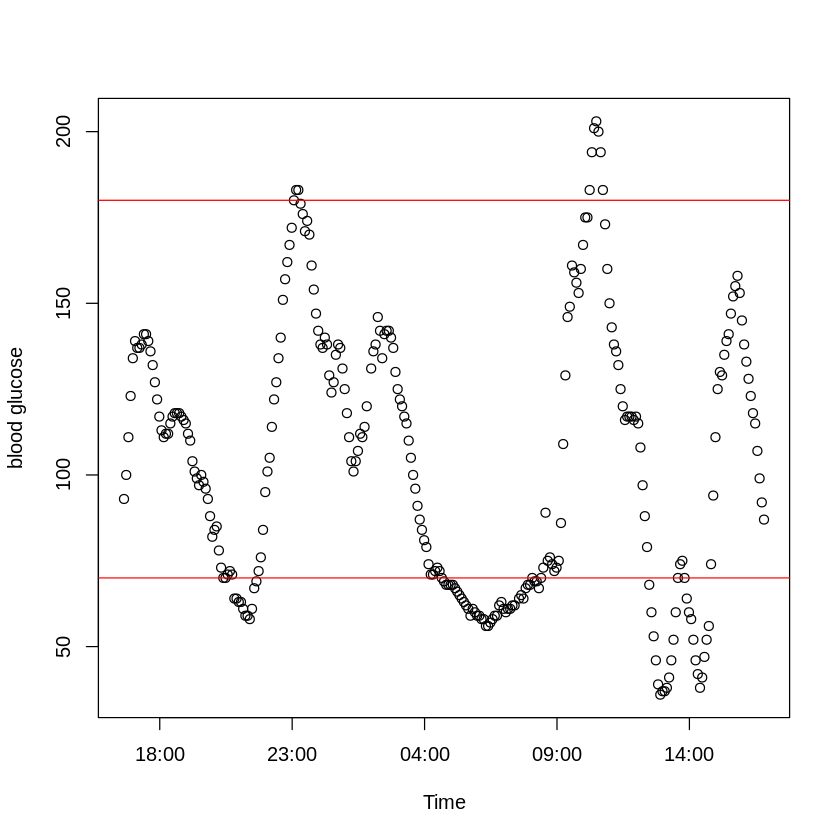

In [8]:
id<-5
day<-3
combined.id<-subset(combined,ID==id)
low.index<- day*288
high.index<-low.index +288
plot(combined.id$DisplayTime[low.index:high.index],combined.id$bg.value[low.index:high.index],
ylab="blood glucose", xlab="Time")
abline(h=70, col=2)
abline(h=180, col=2)

###  CREATE  A LAG VARIABLE

In [9]:
install.packages("DataCombine")
require(DataCombine)
combined<-slide(combined, Var='bg.value', NewVar='bg.value.lag', TimeVar='DisplayTime', GroupVar='ID', slideBy=-1)
combined<- subset(combined, is.na(bg.value.lag)==F )

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: DataCombine

Lagging bg.value by 1 time units.



## CREATE A CUMULATIVE SUM STEPS VARIABLE TO USE AS A PREDICTOR

In [10]:
combined$csum.steps <- ave(combined$steps, combined$ID, FUN=cumsum)

## MODEL THE EFFECTS OF ACTIVITY  ON GLUCOSE ACCOUTING FOR PRIOR GLUCOSE

In [11]:
require(nlme)
mdl<- lme(bg.value~  bg.value.lag + csum.steps + hr.value + Intensity, random=~1|ID, data=combined)
summary(mdl)

Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse



Linear mixed-effects model fit by REML
 Data: combined 
     AIC      BIC    logLik
  335673 335731.5 -167829.5

Random effects:
 Formula: ~1 | ID
        (Intercept) Residual
StdDev:    4.649165 52.04541

Fixed effects: bg.value ~ bg.value.lag + csum.steps + hr.value + Intensity 
                 Value Std.Error    DF  t-value p-value
(Intercept)  13.847014 2.0959054 31216   6.6067  0.0000
bg.value.lag  0.900762 0.0024569 31216 366.6241  0.0000
csum.steps   -0.000197 0.0001087 31216  -1.8095  0.0704
hr.value     -0.010500 0.0209799 31216  -0.5005  0.6168
Intensity    -0.771203 0.5905238 31216  -1.3060  0.1916
 Correlation: 
             (Intr) bg.vl. csm.st hr.val
bg.value.lag -0.151                     
csum.steps   -0.149  0.039              
hr.value     -0.816  0.000 -0.059       
Intensity    -0.012  0.026 -0.044 -0.056

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-6.54664833 -0.17049585 -0.06400235  0.17662376  6.74218030 

N

## FINAL MODEL 

In [12]:
mdl<- lme(bg.value~  bg.value.lag + csum.steps , random=~1|ID, data=combined)
summary(mdl)


Linear mixed-effects model fit by REML
 Data: combined 
       AIC      BIC  logLik
  335665.9 335707.7 -167828

Random effects:
 Formula: ~1 | ID
        (Intercept) Residual
StdDev:    4.628463 52.04557

Fixed effects: bg.value ~ bg.value.lag + csum.steps 
                 Value Std.Error    DF  t-value p-value
(Intercept)  12.827472 1.2001580 31218  10.6882  0.0000
bg.value.lag  0.900856 0.0024560 31218 366.8044  0.0000
csum.steps   -0.000207 0.0001084 31218  -1.9070  0.0565
 Correlation: 
             (Intr) bg.vl.
bg.value.lag -0.263       
csum.steps   -0.351  0.040

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-6.53942703 -0.17010748 -0.06449656  0.17724661  6.74167231 

Number of Observations: 31240
Number of Groups: 20 